In [1]:
# 导入和路径设置
import py4vasp
import pymatgen.core as mg
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.electronic_structure.plotter import DosPlotter, BSPlotter
import sumo.cli.dosplot # For sumo's python api if available, else use subprocess
import sumo.cli.bandplot
import subprocess
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [2]:
# --- 基本路径设置 ---
tutorial_base_path = "." 
path_e01 = os.path.join(tutorial_base_path, "e01_Si-G0W0") # DFT and G0W0
path_e01_unoccupied = os.path.join(path_e01, "unoccupied-states") # Empty bands calc
path_e01_g0w0_single_shot = os.path.join(path_e01, "single-shot") # G0W0 calc
path_e02 = os.path.join(tutorial_base_path, "e02_Si-GW0-band") # GW0
path_e02_band_structure_wannier = os.path.join(path_e02, "band-structure") # Wannier post-processing
# 检查路径是否存在 (可选，但推荐)
for p_check in [path_e01, path_e01_unoccupied, path_e01_g0w0_single_shot, path_e02, path_e02_band_structure_wannier]:
    if not os.path.exists(p_check):
        print(f"警告: 路径 {p_check} 不存在，请确保已按教程创建目录和文件。")
# KPOINTS_OPT 文件路径 (教程中用于能带图)
kpoints_opt_path_e01 = os.path.join(path_e01, "KPOINTS_OPT")

In [ ]:
#  py4vasp - DFT基态能隙和DOS
print("--- 1.2.2.1: py4vasp - DFT基态能隙和DOS ---")
try:
    # py4vasp.Calculation.from_path 会自动寻找 vaspout.h5, vasprun.xml, OUTCAR
    dft_calc_py4vasp = py4vasp.Calculation.from_path(path_e01)
    
    # 获取能隙 (HOMO-LUMO gap from the k-point grid of the SCF calculation)
    # py4vasp 的能隙获取可能没有pymatgen那么直接的 get_band_gap()
    # 教程中的 gap 函数:
    def gap_py4vasp(calc_obj):
        band_data = calc_obj.band.to_dict() # 获取能带和占据数数据
        occupations = np.array(band_data['occupations'])
        bands = np.array(band_data['bands'])
        
        # 确保维度正确，bands可能是 (num_spins, num_kpoints, num_bands) 或 (num_kpoints, num_bands)
        # occupations 类似
        if bands.ndim == 3: # Spin-polarized
            homo = -np.inf
            lumo = np.inf
            for spin_idx in range(bands.shape[0]):
                occupied_bands_spin = bands[spin_idx][occupations[spin_idx] > 0.5]
                unoccupied_bands_spin = bands[spin_idx][occupations[spin_idx] < 0.5]
                if occupied_bands_spin.size > 0:
                    homo = max(homo, np.amax(occupied_bands_spin))
                if unoccupied_bands_spin.size > 0:
                    lumo = min(lumo, np.amin(unoccupied_bands_spin))
        else: # Non-spin-polarized
            occupied_bands = bands[occupations > 0.5]
            unoccupied_bands = bands[occupations < 0.5]
            if occupied_bands.size == 0 or unoccupied_bands.size == 0:
                 print("警告: 未找到占据带或非占据带，无法计算能隙。检查vasp计算。")
                 return None
            homo = np.amax(occupied_bands)
            lumo = np.amin(unoccupied_bands)
            
        if homo == -np.inf or lumo == np.inf:
             print("警告: HOMO或LUMO未找到，无法计算能隙。")
             return None
        return lumo - homo

    pbe_gap_py4vasp = gap_py4vasp(dft_calc_py4vasp)
    if pbe_gap_py4vasp is not None:
        print(f"PBE band gap (from SCF k-points, py4vasp): {pbe_gap_py4vasp:.4f} eV")
    else:
        print("无法使用py4vasp计算PBE能隙。")

    # 绘制DOS
    print("绘制 PBE DOS (py4vasp)...")
    dos_plot_py4vasp = dft_calc_py4vasp.dos.plot() # 返回一个figure对象
    if dos_plot_py4vasp:
        dos_plot_py4vasp.show() # 在notebook中通常会自动显示
        # 如果需要在之后显示，或保存
        # import matplotlib.pyplot as plt # 确保导入
        # plt.show() # 来显示所有打开的图
        # dos_plot_py4vasp.savefig(os.path.join(path_e01, "si_pbe_dos_py4vasp.png"))
        pass # 在Jupyter中，plot()通常会直接显示
    else:
        print("py4vasp未能生成DOS图。")
        
except Exception as e:
    print(f"py4vasp处理DFT基态时出错: {e}")
    print("提示: 确保VASP计算已在 {path_e01} 完成，并且输出了vaspout.h5或vasprun.xml。")


--- 1.2.2.1: py4vasp - DFT基态能隙和DOS ---
PBE band gap (from SCF k-points, py4vasp): 0.7079 eV
绘制 PBE DOS (py4vasp)...


In [ ]:
#  Pymatgen - DFT基态能隙
print("\n--- 1.2.2.2: Pymatgen - DFT基态能隙 ---")
dft_vasprun_path = os.path.join(path_e01, "vasprun.xml")
try:
    if not os.path.exists(dft_vasprun_path):
        raise FileNotFoundError(f"vasprun.xml not found at {dft_vasprun_path}")
        
    run_dft_pmg = Vasprun(dft_vasprun_path)
    if run_dft_pmg.converged:
        bs_dft_pmg = run_dft_pmg.get_band_structure() # 从SCF的k点获取
        gap_info_dft_pmg = bs_dft_pmg.get_band_gap()
        fermi_dft_pmg = run_dft_pmg.efermi

        if gap_info_dft_pmg and gap_info_dft_pmg['energy'] > 0:
            print(f"PBE能隙 (Pymatgen, from SCF vasprun.xml):")
            print(f"  能隙大小: {gap_info_dft_pmg['energy']:.4f} eV")
            print(f"  是否直接带隙: {gap_info_dft_pmg['direct']}")
            vbm_dft_pmg = bs_dft_pmg.get_vbm()
            cbm_dft_pmg = bs_dft_pmg.get_cbm()
            print(f"  VBM: {vbm_dft_pmg['energy']:.4f} eV (E_fermi: {fermi_dft_pmg:.4f} eV)")
            print(f"  CBM: {cbm_dft_pmg['energy']:.4f} eV")
        else:
            print("Pymatgen: PBE计算结果显示为金属或未能确定能隙。")
    else:
        print(f"Pymatgen: SCF计算 ({dft_vasprun_path}) 未收敛。")
except FileNotFoundError:
    print(f"错误: {dft_vasprun_path} 未找到。")
except Exception as e:
    print(f"Pymatgen处理DFT基态vasprun.xml时出错: {e}")



--- 1.2.2.2: Pymatgen - DFT基态能隙 ---
PBE能隙 (Pymatgen, from SCF vasprun.xml):
  能隙大小: 0.5814 eV
  是否直接带隙: False
  VBM: 5.4736 eV (E_fermi: 5.5045 eV)
  CBM: 6.0550 eV


In [ ]:
#  Sumo - DFT基态DOS
print("\n--- 1.2.2.3: Sumo - DFT基态DOS ---")
dft_vasprun_path = os.path.join(path_e01, "vasprun.xml")
dos_image_sumo_path = os.path.join(path_e01, "si_pbe_dos_sumo")
# Sumo 命令行绘图
sumo_dos_cmd = [
    "sumo-dosplot",
    "-f", dft_vasprun_path,             # 使用 -f 指定输入的vasprun.xml
    "--elements", "Si",                 # 指定元素
    "--orbitals", "s,p",            # 使用 --orbitals 指定Si的s,p轨道
    "--xlabel", "Energy (eV)",
    "--ylabel", "DOS (1/eV)", # f.u. = formula unit
    # "--legend-on",                    # 移除，图例通常默认开启
    "--style", "seaborn-v0_8-pastel",
    "--directory", dos_image_sumo_path,  # 指定输出文件名
    # "--nogui"                         # 移除，指定输出文件时通常默认无GUI
]
print(f"执行Sumo命令: {' '.join(sumo_dos_cmd)}")
result = subprocess.run(sumo_dos_cmd, check=True, capture_output=True, text=True)
print(f"Sumo DOS图已保存到: {dos_image_sumo_path}")



--- 1.2.2.3: Sumo - DFT基态DOS ---
执行Sumo命令: sumo-dosplot -f ./e01_Si-G0W0/vasprun.xml --elements Si --orbitals s,p --xlabel Energy (eV) --ylabel DOS (1/eV) --style seaborn-v0_8-pastel --directory ./e01_Si-G0W0/si_pbe_dos_sumo
Sumo DOS图已保存到: ./e01_Si-G0W0/si_pbe_dos_sumo


In [ ]:
#  py4vasp - 绘制PBE能带结构 (尝试使用KPOINTS_OPT)
print("\n--- 1.2.2.4: py4vasp - 绘制PBE能带结构 (尝试使用KPOINTS_OPT) ---")
my_calc = py4vasp.Calculation.from_path("./e01_Si-G0W0/")

my_calc.band.plot("kpoints_opt")



--- 1.2.2.4: py4vasp - 绘制PBE能带结构 (尝试使用KPOINTS_OPT) ---


In [ ]:
# py4vasp - 绘制静电介电函数 (IPA，RPA)即独立粒子近似与随机相位近似
print("\n--- 1.3.2.1: py4vasp - 绘制静电介电函数 (IPA，RPA) ---")
from py4vasp import plot

filename_ipa = "./e01_Si-G0W0/single-shot/dielectric_function_IPA.dat"
# uncomment the following line to use the RPA dielectric function
filename_rpa = "./e01_Si-G0W0/single-shot/dielectric_function_RPA.dat"

# read the dielectric function from file
w_ipa, eps_imag_ipa, eps_real_ipa = np.loadtxt(filename_ipa, unpack=True)
w_rpa, eps_imag_rpa, eps_real_rpa = np.loadtxt(filename_rpa, unpack=True)

# plot the dielectric function as a function of frequency
# DFPT
plot(
    (w_ipa, eps_real_ipa, "Dielectric function (real, IPA)"),
    (w_ipa, eps_imag_ipa, "Dielectric function (imaginary, IPA)"),
    (w_rpa, eps_real_rpa, "Dielectric function (real, RPA)"),
    (w_rpa, eps_imag_rpa, "Dielectric function (imaginary, RPA)"),
    title = "Dielectric function of Si",
    ylabel = "Dielectric function",
    xlabel = "Frequency (eV)",
) 



--- 1.3.2.1: py4vasp - 绘制静电介电函数 (IPA) ---



--- 1.3.2.2: Pymatgen + Matplotlib - 绘制IPA介电函数 ---
Pymatgen IPA介电函数图已保存到: ./e01_Si-G0W0/unoccupied-states/si_dielec_ipa_pymatgen.png


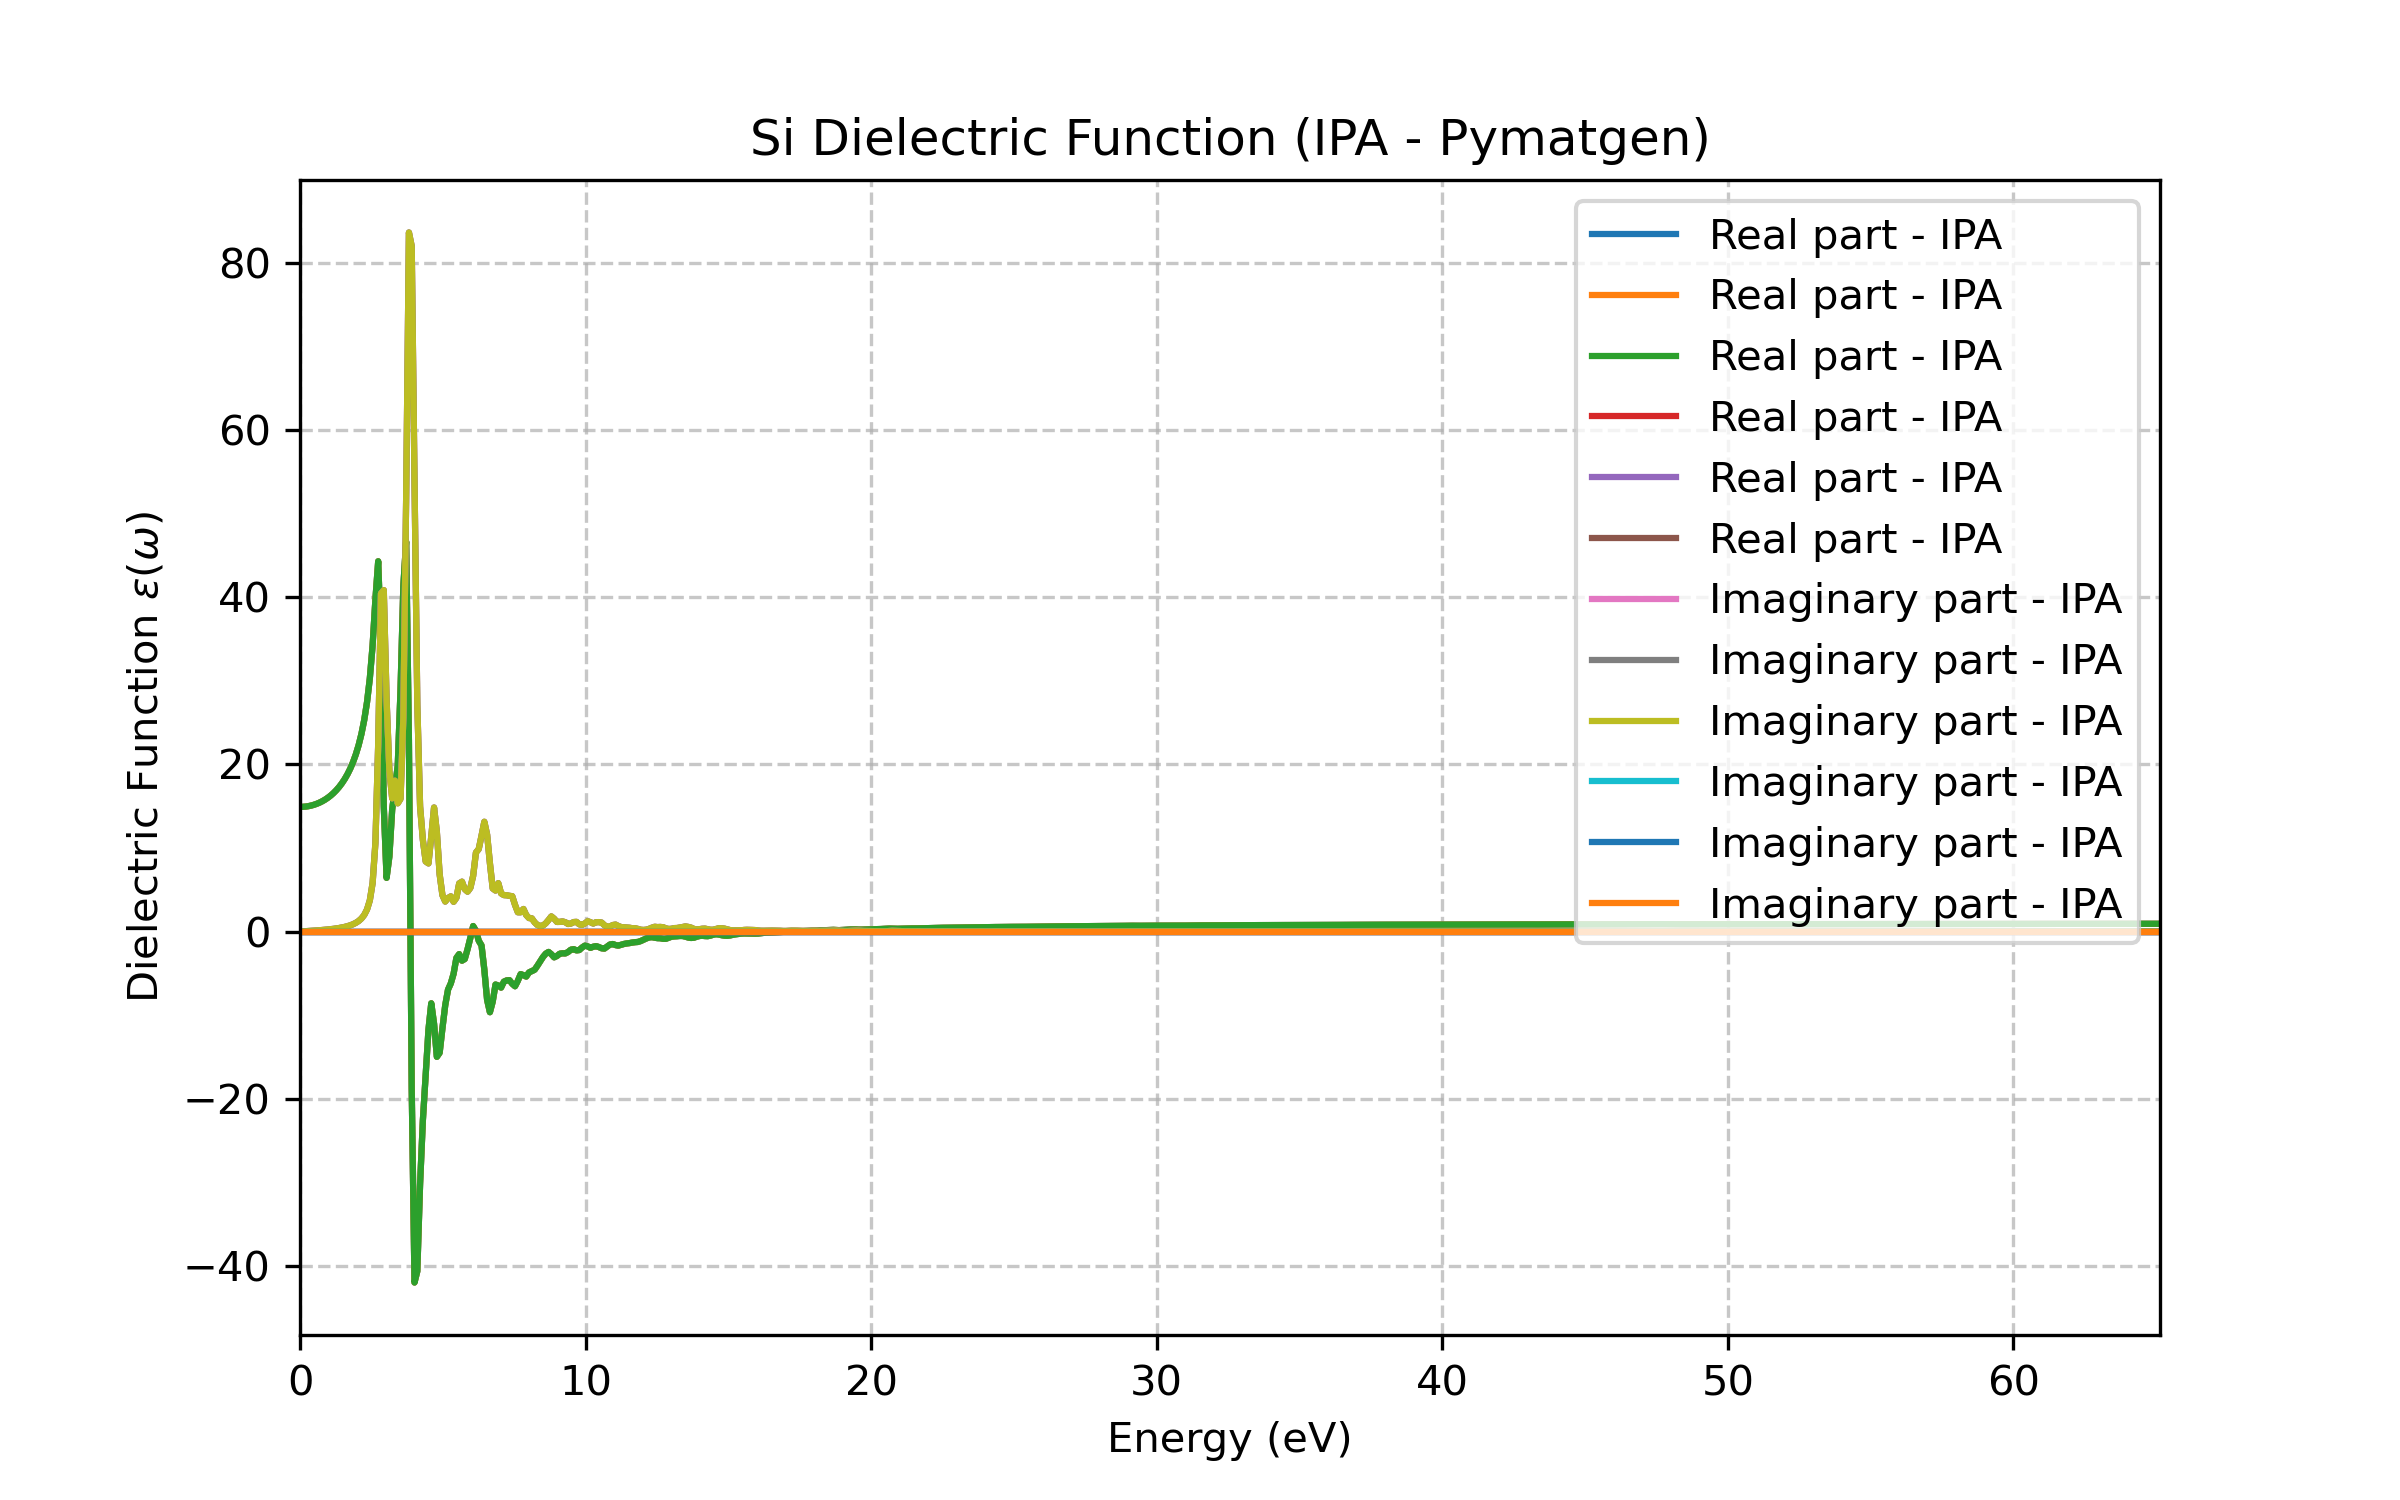

In [28]:
#  Pymatgen + Matplotlib - 绘制IPA介电函数
print("\n--- 1.3.2.2: Pymatgen + Matplotlib - 绘制IPA介电函数 ---")
unoccupied_vasprun_path = os.path.join(path_e01_unoccupied, "vasprun.xml")
dielec_ipa_pmg_path = os.path.join(path_e01_unoccupied, "si_dielec_ipa_pymatgen.png")

if not os.path.exists(unoccupied_vasprun_path):
    print(f"错误: {unoccupied_vasprun_path} 未找到。")
else:
    try:
        run_optics_pmg = Vasprun(unoccupied_vasprun_path, parse_potcar_file=False)
        
        energy_pmg = run_optics_pmg.dielectric[0]
        eps_real_pmg = run_optics_pmg.dielectric[1] # 对角元平均
        eps_imag_pmg = run_optics_pmg.dielectric[2] # 对角元平均

        plt.figure(figsize=(8, 5))
        plt.plot(energy_pmg, eps_real_pmg, label="Real part - IPA")
        plt.plot(energy_pmg, eps_imag_pmg, label="Imaginary part - IPA")
        plt.xlabel("Energy (eV)")
        plt.ylabel("Dielectric Function $\\epsilon (\\omega)$")
        plt.title("Si Dielectric Function (IPA - Pymatgen)")
        plt.legend(loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.7)
        if len(energy_pmg) > 0: plt.xlim(min(energy_pmg), max(energy_pmg)/1.5 if max(energy_pmg) > 0 else 10)
        
        plt.savefig(dielec_ipa_pmg_path, dpi=300)
        plt.close() # 关闭图像，避免在notebook中重复显示
        print(f"Pymatgen IPA介电函数图已保存到: {dielec_ipa_pmg_path}")
        display(Image(filename=dielec_ipa_pmg_path))

    except Exception as e:
        print(f"Pymatgen处理介电函数 ({unoccupied_vasprun_path}) 时出错: {e}")


In [32]:
#  py4vasp - G0W0准粒子能隙
print("\n--- 1.4.2.1: py4vasp - G0W0准粒子能隙 ---")
g0w0_calc_py4vasp = py4vasp.Calculation.from_path(path_e01_g0w0_single_shot)
q_gap_g0w0_py4vasp = gap_py4vasp(g0w0_calc_py4vasp) 
print(f"G0W0 quasiparticle band gap (py4vasp, from {path_e01_g0w0_single_shot}): {q_gap_g0w0_py4vasp:.4f} eV")


--- 1.4.2.1: py4vasp - G0W0准粒子能隙 ---
G0W0 quasiparticle band gap (py4vasp, from ./e01_Si-G0W0/single-shot): 1.2139 eV


In [6]:
from py4vasp import Calculation

calc = Calculation.from_path("./e01_Si-G0W0/single-shot")
calc.dielectric_function.plot("Re(IPA, RPA)")

In [ ]:
import py4vasp
e02_calc = py4vasp.Calculation.from_path("./e01_Si-G0W0")

d = e02_calc.band.to_dict(selection="kpoints_opt")

#  wannier90_band.dat 第一列最后一行
x = 0.51924171E+01

with open("./e02_Si-GW0-band/band-structure/e01_kpoints_opt_band.dat", "w") as f:
    for i in range(8):
        for k in range(60):
            f.write(str(d['kpoint_distances'][k]/d['kpoint_distances'][-1]*x) + " " + str(d['bands'][k, i]+d['fermi_energy']) + "\n")
        f.write("\n")
        
print("DFT E-fermi: ", d['fermi_energy'])
e02_calc.band.plot(selection="kpoints_opt")

DFT E-fermi:  5.628076698968314


## 接下来生成对比，用wannier90局域插值的和DFT（PBE）的能带进行对比。

```shell
echo """

set out 'band_DFT_vs_GW.png'
plot 'wannier90_band.dat', 'e01_kpoints_opt_band.dat' w l, 5.628

""" >> band.gp
gnuplot band.gp
```


![band_DFT_vs_GW.png](./figures/band_DFT_vs_GW.png)
